## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from models import customLogisticRegression
from parameters import ParameterProxy
from lib2 import valid_ifthens_with_coverage_correctness, rules2rulesbyif
import lib2
from formatting import recourse_report_reverse

import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"

## Load Dataset

In [3]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


### Print some statistics for the dataset

In [4]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

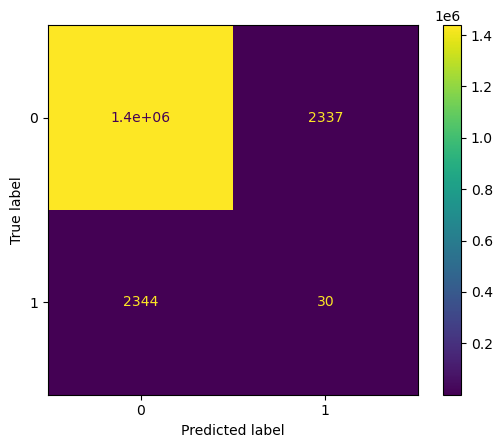

In [5]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [6]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,F,1,55-64,Unknown,Unknown,1,1,0
3,F,1,55-64,Unknown,Unknown,1,1,0
4,F,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,F,1,25-34,Unknown,Unknown,1,1,0
1443136,F,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,F,1,55-64,Unknown,Unknown,1,1,0


In [7]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [8]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

CPU times: total: 1.3 s
Wall time: 6.57 s


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

# Testing the model

We check if the model is satisfactory.

In [9]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    432231
           1       0.00      0.09      0.00       712

    accuracy                           0.92    432943
   macro avg       0.50      0.51      0.48    432943
weighted avg       1.00      0.92      0.96    432943



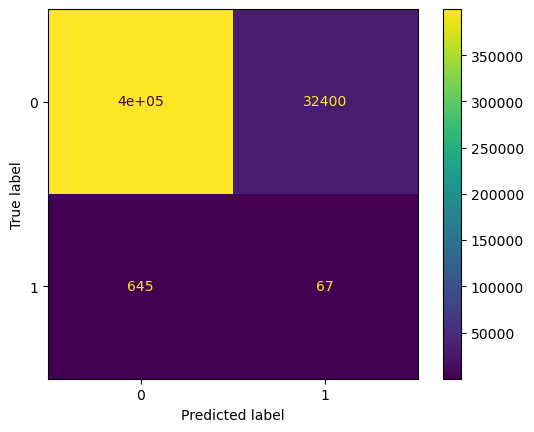

In [10]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model,
    sensitive_attribute,
    missing_subgroup_val="Unknown"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:39<00:00,  6.68it/s]

Number of if-thens: 266


Uncomment the following block if you wish to load rules object from disk.

In [12]:
# import dill

# with open("rules.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [13]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If homeowner = 0, age = 55-64, income = <100K, college_educated = 1, parents = 1:
	Subgroup 'F', 1.1943% covered
		Make homeowner = 0, age = 55-64, income = Unknown, college_educated = 1, parents = 1 with correctness 100.0000%.
	Subgroup 'M', 1.1988% covered
		Make homeowner = 0, age = 55-64, income = Unknown, college_educated = 1, parents = 1 with correctness 1.8800%.
If income = Unknown, homeowner = 0, area = Unknown, age = 55-64:
	Subgroup 'F', 1.0521% covered
		Make income = >100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 0.0000%.
	Subgroup 'M', 9.3847% covered
		Make income = >100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 89.5128%.
If income = Unknown, homeowner = 1, area = Unknown, parents = 1:
	Subgroup 'F', 62.1400% covered
		Make income = Unknown, homeowner = 0, area = Unknown, parents = 1 with correctness 89.9585%.
		Make income = >100K, homeowner = 0, area = Unknown, parents = 1 with correctness 91.6870%.
	Subgroup 'M', 56.5904% covered

In [14]:
##### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [15]:
comparators = lib2.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## For each if-group, inner product of then costs and correctness-es, divided by the number of terms

In [16]:
rules_max_costdiff_sorted = lib2.sort_triples_by_max_costdiff(rules_by_if, params=params)

top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=lib2.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If homeowner = 0, age = 55-64, income = <100K, college_educated = 1, parents = 1:
	Subgroup 'F', 1.1943% covered out of 600135
		Make homeowner = 0, age = 55-64, income = Unknown, college_educated = 1, parents = 1 with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 1.1988% covered out of 314181
		Make homeowner = 0, age = 55-64, income = Unknown, college_educated = 1, parents = 1 with correctness 1.8800%.
		Aggregate cost of the above recourses = 0.0188004
If income = Unknown, homeowner = 0, area = Unknown, age = 55-64:
	Subgroup 'F', 1.0521% covered out of 600135
		Make income = >100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'M', 9.3847% covered out of 314181
		Make income = >100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 89.5128%.
		Aggregate cost of the above recourses = 0.895128
If income = Unknown, homeowner = 0, age = 55-64:
	Subgroup 'F', 1

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

In [17]:
rules_max_costdiff_sorted = lib2.sort_triples_by_max_costdiff_ignore_nans(
    rules_by_if,
    params=params,
    group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = pop_sizes,
    subgroup_costs=lib2.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
        cor_thres=0.5
    )
))

If homeowner = 1:
	Subgroup 'F', 96.8523% covered out of 600135
		Make homeowner = 0 with correctness 86.5286%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 88.5750% covered out of 314181
		Make homeowner = 0 with correctness 28.7733%.
		Aggregate cost of the above recourses = inf
If homeowner = 1, parents = 1:
	Subgroup 'F', 91.6921% covered out of 600135
		Make homeowner = 0, parents = 1 with correctness 91.3782%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 83.8054% covered out of 314181
		Make homeowner = 0, parents = 1 with correctness 30.4057%.
		Aggregate cost of the above recourses = inf
If homeowner = 1, college_educated = 1:
	Subgroup 'F', 91.3996% covered out of 600135
		Make homeowner = 0, college_educated = 1 with correctness 90.0813%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 83.5940% covered out of 314181
		Make homeowner = 0, college_educated = 1 with correctness 30.1771%.
		Aggregate cost of the above recourses = inf
I

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

Before, when, for a subgroup, there were no thens that surpassed the threshold, the minimum cost of change was valued as infinity, and thus, as it is evident in the results, the algorithm finds many rules for which some groups surpass the threshold and some groups do not (because for those rules the difference between maximum and minimum cost of the subgroups evaluates to infinity).

Here, the difference is that we will ignore altogether rules for which the correctness drops below the threshold for all recourses (for some subgroup), considering them as "empty".

In [19]:
rules_max_costdiff_sorted = lib2.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules_by_if,
    params=params,
    group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    lib2.filter_by_correctness(top, threshold=0.5),
    population_sizes = pop_sizes,
    subgroup_costs=lib2.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
        cor_thres=0.5
    )
))

If income = Unknown, homeowner = 1:
	Subgroup 'F', 94.0490% covered out of 600135
		Make income = Unknown, homeowner = 0 with correctness 87.9884%.
		Make income = >100K, homeowner = 0 with correctness 90.6159%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 85.9745% covered out of 314181
		Make income = >100K, homeowner = 0 with correctness 88.2629%.
		Aggregate cost of the above recourses = 2.0
If income = Unknown, homeowner = 1, parents = 1:
	Subgroup 'F', 89.0500% covered out of 600135
		Make income = Unknown, homeowner = 0, parents = 1 with correctness 92.9203%.
		Make income = >100K, homeowner = 0, parents = 1 with correctness 94.1545%.
		Aggregate cost of the above recourses = 1.0
	Subgroup 'M', 81.3412% covered out of 314181
		Make income = >100K, homeowner = 0, parents = 1 with correctness 93.0002%.
		Aggregate cost of the above recourses = 2.0
If income = Unknown, homeowner = 1, college_educated = 1:
	Subgroup 'F', 88.7582% covered out of 600135
		Make income = 

# DEBUG INFO

In [21]:
subgroup_costs = lib2.calculate_all_if_subgroup_costs(
        list(rules_by_if.keys()),
        list(rules_by_if.values()),
        group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
        cor_thres=0.5
    )

x = pd.Series([cost for ifc, costs in subgroup_costs.items() for sg, cost in costs.items()])
x.value_counts()

inf    198
1.0     93
2.0     37
3.0      2
dtype: int64

In [23]:
x = pd.Series([[cost for sg, cost in costs.items()] for ifc, costs in subgroup_costs.items()])
x.value_counts()

[inf, inf]    91
[1, 1]        35
[2, 2]        14
[1, inf]      11
[1, 2]         8
[inf, 1]       4
[inf, 2]       1
[3, 3]         1
dtype: int64